In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ternary

In [128]:
#Import the data and flip into a multi index 

def data_retrieval(sourcefile, pt_initials):
    df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
    df = df.stack([0,1,2])
    df = df.reorder_levels([1,0,2,3])
    df = df.to_frame()  #puts everything back in a dataframe
    df.columns = ['Reads']
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Amplicon'] = df.index.get_level_values(2)
    df['Genotype'] = df.index.get_level_values(3)
    df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
    df = df.drop(columns = ['one', 'two'])

    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID') #should this be an input? also in next fucntion
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))

    #Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
    #RN_allele_plate is the key dataset going forward
    pt_allele_plate = df.loc[df['Patient'].isin([pt_initials])] #Make df with just RN data
    pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
    pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
    pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)
    
    return pt_allele_plate

def call_haps (data, haps, reads, cutoff):

#data is the df created by data_retrieval
#haps is the number of haplotypes
#reads is the number of reads per amplicon
#cutoff is the threshold for calling an amplicon as mutant
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Create possible haplotypes for RN and associated colour palettes

    #4 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    thirda = ['B', 'b']
    fourtha = ['R', 'r']
    hap_4gene_poss =[]

    for a in firsta:
        for b in seconda:
            for c in thirda:
                for d in fourtha:
                    hap_4gene_poss.append(a+b+c+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_4gene_order = dict(zip(hap_4gene_poss, order))

    num_cols = len(hap_4gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_4gene = dict(zip(hap_4gene_poss, cols))
    hap_4_col = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']

    #3 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    fourtha = ['R', 'r']
    hap_3gene_poss =[] 

    for a in firsta:
        for b in seconda:
            for d in fourtha:
                hap_3gene_poss.append(a+b+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_3gene_order = dict(zip(hap_3gene_poss, order))

    num_cols = len(hap_3gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_3gene = dict(zip(hap_3gene_poss, cols))
    hap_3_col = [ 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']

    #2 gene haplotype order and palette
    firsta = ['C', 'c']
    seconda = ['R', 'r']
    hap_2gene_poss =[]

    for a in firsta:
        for b in seconda:
            hap_2gene_poss.append(a+b)

    order = [0, 1, 2, 3]
    hap_2gene_order = dict(zip(hap_2gene_poss, order))

    num_cols = len(hap_2gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_2gene = dict(zip(hap_2gene_poss, cols))
    hap_2_col = ['RN_RUNX1_c', 'RN_RUNX1_g']
    
    if haps == 4:
        cols = hap_4_col
    
    elif haps == 2:
        cols = hap_2_col
        
    elif haps == 3:
        cols = hap_3_col
        
    else:
        print('Enter 2, 3, or 4 haplotypes')
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = ['RN_RUNX1_c','RN_RUNX1_g','RN_SRSF2','RN_TET2a','RN_TET2b_c','RN_TET2b_g']
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads for {haps} genes = ', len(wells))
    
    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']

    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = ['w', 'm']
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols
    
    if 'RN_RUNX1_g' in df2.columns:
        df2.loc[:,'RN_RUNX1_g'].replace({'w':'R','m':'r' }, inplace = True)
        
    if 'RN_SRSF2' in df2.columns:  
        df2.loc[:,'RN_SRSF2'].replace({'w':'S','m':'s' }, inplace = True)
        
    if 'RN_TET2a' in df2.columns:     
        df2.loc[:,'RN_TET2a'].replace({'w':'A','m':'a' }, inplace = True)
        
    if 'RN_TET2b_g' in df2.columns:
        df2.loc[:,'RN_TET2b_g'].replace({'w':'B','m':'b' }, inplace = True)
        
    if 'RN_RUNX1_c' in df2.columns:   
        df2.loc[:,'RN_RUNX1_c'].replace({'w':'C','m':'c' }, inplace = True)
        
    df2['Haplotype'] = 'x'

    for idx, row in df2.iterrows():
        
        if haps == 3:
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_RUNX1_g']
        elif haps == 4:
            a = row['RN_SRSF2'] + row['RN_TET2a'] + row['RN_TET2b_g'] + row['RN_RUNX1_g']
        elif haps ==2:
            a = row['RN_RUNX1_c'] + row['RN_RUNX1_g']
        
        row['Haplotype'] = row['Haplotype'].replace('x', a)   
    
    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = cols)
    df2 = df2.drop(columns = ['Plate', 'Well'])

    return df2

def plot_hap_dist_sort_type(data):
    
    #4 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    thirda = ['B', 'b']
    fourtha = ['R', 'r']
    hap_4gene_poss =[]

    for a in firsta:
        for b in seconda:
            for c in thirda:
                for d in fourtha:
                    hap_4gene_poss.append(a+b+c+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_4gene_order = dict(zip(hap_4gene_poss, order))

    num_cols = len(hap_4gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_4gene = dict(zip(hap_4gene_poss, cols))
    hap_4_col = ['RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a', 'RN_TET2b_g']

    #3 gene haplotype order and palette
    firsta = ['S', 's']
    seconda = ['A', 'a']
    fourtha = ['R', 'r']
    hap_3gene_poss =[] 

    for a in firsta:
        for b in seconda:
            for d in fourtha:
                hap_3gene_poss.append(a+b+d)

    order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
    hap_3gene_order = dict(zip(hap_3gene_poss, order))

    num_cols = len(hap_3gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_3gene = dict(zip(hap_3gene_poss, cols))
    hap_3_col = [ 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']

    #2 gene haplotype order and palette
    firsta = ['C', 'c']
    seconda = ['R', 'r']
    hap_2gene_poss =[]

    for a in firsta:
        for b in seconda:
            hap_2gene_poss.append(a+b)

    order = [0, 1, 2, 3]
    hap_2gene_order = dict(zip(hap_2gene_poss, order))

    num_cols = len(hap_2gene_poss)
    cols = sns.color_palette("husl", num_cols)
    col_2gene = dict(zip(hap_2gene_poss, cols))
    hap_2_col = ['RN_RUNX1_c', 'RN_RUNX1_g']
    
    #rename the input data and work out how many haplotypes it has
    df3 = data.copy()
    haps = len(df3.iloc[0,0])
    sortcells = [ 'nBCs', 'CD34', 'CD34+/38-', 'NEs', 'Monocytes']
    cellnumb = len(sortcells)
    indexcells = df3['celltype'].drop_duplicates().to_list() #don't really need this line, but might use later
    
    #Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
    fig, axes = plt.subplots(3,2, figsize = (16,8))
    fig.subplots_adjust(hspace = 0.8, wspace=.3)
    ax = axes.ravel()
    count = 0

    c = df3['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

    #set up correct variables for the number of input haplotypes
    
    if haps == 2:
        hap_poss = hap_2gene_poss
        hap_order = hap_2gene_order
        color = col_2gene
        
    if haps == 3:
        hap_poss = hap_3gene_poss
        hap_order = hap_3gene_order
        color = col_3gene
        
    if haps == 4:
        hap_poss = hap_4gene_poss
        hap_order = hap_4gene_order
        color = col_4gene
        
    #if any haplotype is not present, add it into the frame with freq 0 

    for h in hap_poss:
        if h not in str(c['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
            dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
            c = c.append(dfh)

    c['order'] = c['hap']
    c = c.replace({'order': hap_3gene_order})
    c = c.sort_values(by=['order'])
    d = c['counts'].sum()
    c['proportion'] = c['counts']/d

    ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = color, ax = ax[count], ci = None) #fro scatter add  hue = 'hap'
    ax[0].set_title('All cells') 
    ax[0].set_ylabel('Number of cells', fontsize = 14)
    ax[0].set_xlabel('Haplotype', fontsize = 14)
    ax[0].tick_params(axis='x', labelrotation = 90)

    
    
    for cell in sortcells:
        count += 1
    
        if df3.loc[df3['Sort_cell_type'].isin([cell])].empty == False:

            a = df3.loc[df3['Sort_cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

            #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
            for h in hap_poss:
                if h not in str(a['hap']):  #for some reason this needs to be called as a string, wasn't needed outside function
                    dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                    a = a.append(dfh)    

            a['order'] = a['hap']
            a = a.replace({'order': hap_order})
            a = a.sort_values(by=['order'])
            b = a['counts'].sum()
            a['proportion'] = a['counts']/b

            ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = color,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
            ax[count].set_title(str(cell)) 
            ax[count].set_ylabel('Number of cells', fontsize = 14)
            ax[count].set_xlabel('Haplotype', fontsize = 14)
            ax[count].tick_params(axis='x', labelrotation = 90)

        else:
            continue
            
#Now plot the heatmaps

def plot_index_heatmap(data, title):
    df = data.copy()
    #b = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)    #cell counts per hap per celltype for later
    a = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    #a = a * 100 /a.sum(axis = 0)
    #How to control order if a different set of cell types are represented?   
    alltypes = ['HSC','MPP','HEALTHY_SC','CMP',  'GMP','GMP2', 'MEP', 'MDS_SC',  'NE', 'Mono','nBC', 'unassigned']
    col_order = {}            
    for i, typ in enumerate(alltypes):
         col_order[typ] = i

    a = a.T
    a['ct'] = a.index.get_level_values(0)
    a = a.replace({'ct': col_order})
    a = a.sort_values(by=['ct'])
    a = a.drop(columns = ['ct'])
    a = a.T
    b = a.copy()
    a = a * 100 /a.sum(axis = 0)

    fig, ax = plt.subplots(figsize = (16, 6))
    sns.heatmap(data = a, ax = ax)
    ax.tick_params(axis='y', labelrotation = 0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)  
    
    x = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    y = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    x = x.sum(axis = 0)
    x = x.to_frame()
    x['order'] = x.index.get_level_values(0)
    x = x.replace({'order': col_order})
    x = x.sort_values(by=['order'])
    x = x.drop(columns = ['order'])
    x['ct'] = x.index.get_level_values(0)
    x.columns = ['number', 'ct']

    
    fig2, ax2 = plt.subplots(figsize = (12.8, 1))
    sns.scatterplot(x = 'ct', y = 'number', data = x, ax = ax2, s = 100, color = 'green')
    ax2.tick_params(axis='x', labelrotation = 90)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.axhline(10, ls = '--', c = 'gray')
    ax2.axhline(100, ls = '--', c = 'gray')
    ax2.set_ylim(1,1001)
    ax2.set_yticks([1,10, 100, 1000])
    ax2.set_yticklabels(['1','10', '100','1000]'])    
    ax2.set_yscale('log') #use this only with scatterplot
    ax2.set_title('Total number of cells for each type')  
    
    return b

def plot_index_heatmap_small(data, title):
    df = data.copy()
    #b = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)    #cell counts per hap per celltype for later
    a = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    #a = a * 100 /a.sum(axis = 0)
    #How to control order if a different set of cell types are represented?   
    alltypes = ['HSC','MPP','HEALTHY_SC','CMP',  'GMP','GMP2', 'MEP', 'MDS_SC',  'NE', 'Mono','nBC']
    col_order = {}            
    for i, typ in enumerate(alltypes):
         col_order[typ] = i

    a = a.T
    a['ct'] = a.index.get_level_values(0)
    a = a.replace({'ct': col_order})
    a = a.sort_values(by=['ct'])
    a = a.drop(columns = ['ct'])
    a = a.T
    b = a.copy()
    a = a * 100 /a.sum(axis = 0)

    fig, ax = plt.subplots(figsize = (12, 4))
    sns.heatmap(data = a, ax = ax,  cmap = 'viridis')
    ax.tick_params(axis='y', labelrotation = 0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.set_title(title)  
    
    x = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    y = df.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
    x = x.sum(axis = 0)
    x = x.to_frame()
    x['order'] = x.index.get_level_values(0)
    x = x.replace({'order': col_order})
    x = x.sort_values(by=['order'])
    x = x.drop(columns = ['order'])
    x['ct'] = x.index.get_level_values(0)
    x.columns = ['number', 'ct']

    fig.savefig('../Results/Haplotypes/RNsmall_heatmap.png',bbox_inches='tight',dpi=300)
    
    fig2, ax2 = plt.subplots(figsize = (12.8, 1))
    sns.scatterplot(x = 'ct', y = 'number', data = x, ax = ax2, s = 100, color = 'green')
    ax2.tick_params(axis='x', labelrotation = 90)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.axhline(10, ls = '--', c = 'gray')
    ax2.axhline(100, ls = '--', c = 'gray')
    ax2.set_ylim(1,1001)
    ax2.set_yticks([1,10, 100, 1000])
    ax2.set_yticklabels(['1','10', '100','1000]'])    
    ax2.set_yscale('log') #use this only with scatterplot
    ax2.set_title('Total number of cells for each type')  
    
    return b

In [3]:
#QC just checking the output is the same.
#The columns (L-R) are; [('Reads', 'RN_RUNX1_c'), ('Reads', 'RN_RUNX1_g'), ('Reads', 'RN_SRSF2'), ('Reads', 'RN_TET2a'), ('Reads', 'RN_TET2b_c'), ('Reads', 'RN_TET2b_g')]
#Cells with 100 reads for 3 genes (plate1) =  794
#Cells with 15 reads for 4 genes (plate2) =  162
#Cells with 50 reads for RUNX1 cDNA and gDNA (plate3) =  1645
#Cells with 10 reads for 4 genes (plate4) =  253
#Cells with 50 reads for 3 genes (plate5) =  1234

Cells with 20 reads for 3 genes =  1793


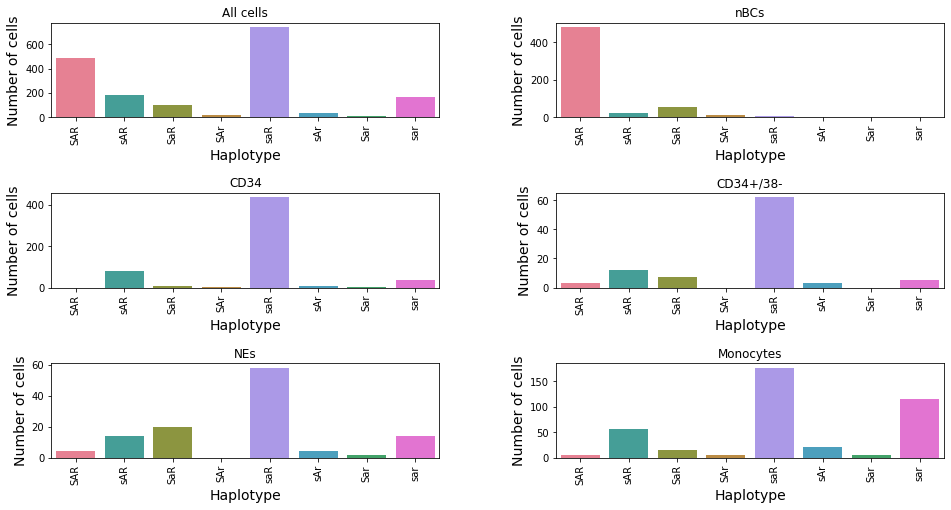

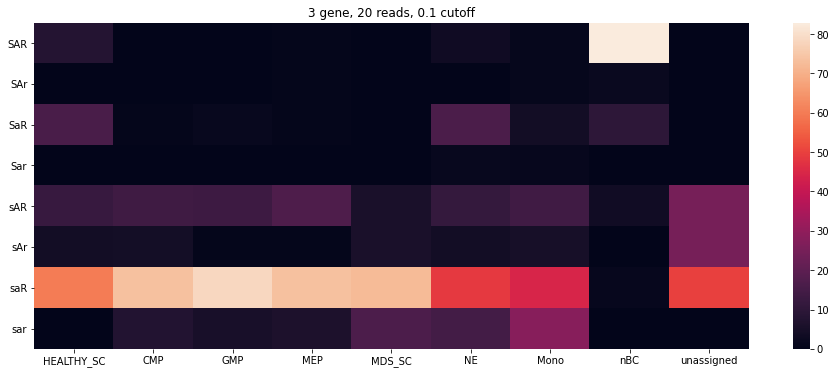

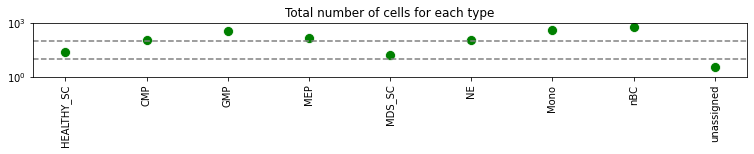

In [85]:
datafile = '../Data/Amp_data/allele_counts.tsv'
index_data = pd.read_csv('../Data/Amp_data/RN_comp_celltype_assignment.tsv', index_col = 0, sep = '\t')
RN_plate = data_retrieval(datafile, 'RN')  
RN_haps = call_haps(RN_plate, 3, 20, 0.1) #hap number, read cut, proprtion mutated
RN_haps_indexed = pd.merge(RN_haps, index_data, on = 'Plate_Well')
plot_hap_dist_sort_type(RN_haps_indexed)
cell_number = plot_index_heatmap(RN_haps_indexed, '3 gene, 20 reads, 0.1 cutoff')


In [5]:
RN_haps_indexed

,Haplotype,Sort_cell_type,Plate_Well,FSC-A,FSC-W,FSC-H,SSC-A,SSC-W,SSC-H,CD34-PE,...,CD27_neg,CD66b_pos,CD66b_neg,CD16_pos,CD16_neg,CD14_pos,CD14_neg,nBC,NE,Mono
0,SaR,nBCs,AS-196_A2,58820.400,86627.87,44499.0,16419.510,77376.070,13907.0,NaN,...,True,False,True,False,True,False,True,True,False,False
1,SAR,nBCs,AS-196_A4,57884.400,84380.90,44957.0,37790.190,79557.270,31130.0,NaN,...,True,False,True,False,True,False,True,True,False,False
2,SAR,nBCs,AS-196_A6,67003.195,86584.27,50715.0,57530.492,80928.960,46588.0,NaN,...,True,False,True,False,True,False,True,True,False,False
3,SAR,nBCs,AS-196_A8,50176.797,81190.72,40502.0,15474.690,73874.520,13728.0,NaN,...,True,False,True,False,True,False,True,True,False,False
4,SAR,nBCs,AS-196_A9,59012.098,87668.70,44114.0,56853.630,77709.960,47947.0,NaN,...,True,False,True,False,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,saR,NEs,AS-189_I17,149435.100,110113.42,88939.0,124906.770,103290.690,79251.0,NaN,...,True,True,False,True,False,False,True,False,True,False
1750,saR,NEs,AS-189_I18,138434.390,109455.49,82887.0,114133.560,103629.280,72179.0,NaN,...,True,True,False,True,False,False,True,False,True,False
1751,SaR,NEs,AS-189_J13,123738.300,100092.74,81018.0,111769.770,86945.010,84248.0,NaN,...,True,True,False,True,False,True,False,False,True,False
1752,saR,NEs,AS-189_N3,167827.500,113507.29,96899.0,139826.400,97505.484,93981.0,NaN,...,True,True,False,True,False,True,False,False,True,False


In [6]:
#How many WT cells for each type
k = cell_number.loc[['SAR', 'sAR', 'saR', 'sar']]
#k = cell_number.loc[['SAr', 'SaR', 'Sar', 'sAr']]
k

celltype,HEALTHY_SC,CMP,GMP,MEP,MDS_SC,NE,Mono,nBC,unassigned
Haplotype,,,,,,,,,
SAR,2,0,0,1,0,4,5,479,0
sAR,3,16,47,24,1,14,56,22,1
saR,15,86,278,104,13,60,175,8,2
sar,0,9,19,9,3,18,111,0,0


In [131]:
#how many cells?
#How to refine nBC/any cell type for number of non-WT cells 
y = cell_number.loc[['sAR', 'saR', 'sar']]
y = y*100/y.sum(axis = 0)
y = y.drop(columns = ['unassigned'])
y2 = y[['HEALTHY_SC','MDS_SC','CMP',  'GMP', 'MEP',   'NE', 'Mono','nBC']]
y2

celltype,HEALTHY_SC,MDS_SC,CMP,GMP,MEP,NE,Mono,nBC
Haplotype,,,,,,,,
sAR,16.666667,5.882353,14.414414,13.662791,17.518248,15.217391,16.374269,73.333333
saR,83.333333,76.470588,77.477477,80.813953,75.912409,65.217391,51.169591,26.666667
sar,0.000000,17.647059,8.108108,5.523256,6.569343,19.565217,32.456140,0.000000


In [133]:
y

celltype,HEALTHY_SC,CMP,GMP,MEP,MDS_SC,NE,Mono,nBC
Haplotype,,,,,,,,
sAR,16.666667,14.414414,13.662791,17.518248,5.882353,15.217391,16.374269,73.333333
saR,83.333333,77.477477,80.813953,75.912409,76.470588,65.217391,51.169591,26.666667
sar,0.000000,8.108108,5.523256,6.569343,17.647059,19.565217,32.456140,0.000000


In [138]:
#How many mutated cells for each type
j = cell_number.loc[['SAR','sAR', 'saR', 'sar']]

j.sum(axis = 0)


celltype
HEALTHY_SC     20
CMP           111
GMP           344
MEP           138
MDS_SC         17
NE             96
Mono          347
nBC           509
unassigned      3
dtype: int64

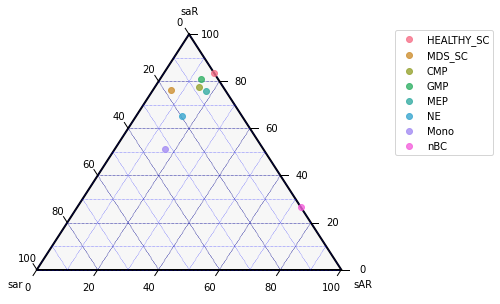

In [141]:
#Straight ternary plot
colors = sns.color_palette('husl', n_colors = y2.shape[1])

fig, tax = ternary.figure(scale = 100)
fig.set_size_inches(6,5)

for i, celltype in enumerate(y2.columns):
    tax.scatter([y2[celltype]], marker='o', zorder = 10,alpha = 0.8, label=celltype, color = colors[i])
    
tax.legend(loc = 'upper left', bbox_to_anchor = [1.1,1],  bbox_transform = plt.gca().transAxes )

 # Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=20)
tax.gridlines(color="blue", multiple=10, linewidth=0.5)

# Set Axis labels and Title
fontsize = 10
#tax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
#tax.left_axis_label("Left label $\\alpha^2$", fontsize=fontsize)
#tax.right_axis_label("Right label $\\beta^2$", fontsize=fontsize)
#tax.bottom_axis_label("Bottom label $\\Gamma - \\Omega$", fontsize=fontsize)

tax.right_corner_label("sAR", fontsize=fontsize)
tax.top_corner_label("saR", fontsize=fontsize)
tax.left_corner_label("sar", fontsize=fontsize)
tax.ticks(axis='lbr', multiple=20, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

fig.savefig('../Results/Haplotypes/RN_Ternary_3hap.png',bbox_inches='tight',dpi=300)

In [10]:
#Now let's create a cloud to reflect certainty of probabilities
from scipy.stats import multinomial

In [11]:
#General case for multinomial
dist = multinomial(100, p=[0.8, 0.15, 0.05])
dist.rvs(1000).std(axis = 0)

array([4.02284427, 3.55776278, 2.21943777])

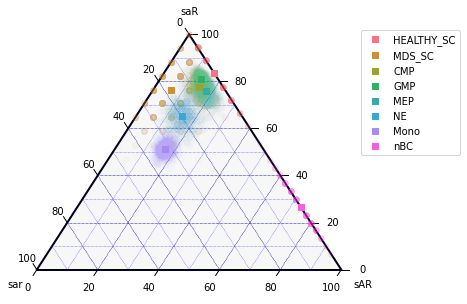

In [137]:
colors = sns.color_palette('husl', n_colors = y2.shape[1])
ndict = j.sum(axis = 0)
fig, tax = ternary.figure(scale = 100)
fig.set_size_inches(6,5)
#celltype = 'NE'

for i, celltype in enumerate(y2.columns):
    tax.scatter([y2[celltype]], marker='s', zorder = 10, label=celltype, color = colors[i]) #plot the average of all

    n=ndict.loc[celltype] #number of cells inthis cell type
    p = y2[celltype]/100 #return proprtion to probability of being each haplotype
    dist = multinomial(n, p=p)
    points = dist.rvs(1000)/n*100
    tax.scatter(points, marker='o', zorder = 5, alpha = 0.01, color = colors[i]) #plot the calculated variation

tax.legend(loc = 'upper left', bbox_to_anchor = [1,1],  bbox_transform = plt.gca().transAxes )
 # Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=20)
tax.gridlines(color="blue", multiple=10, linewidth=0.5)

# Set Axis labels and Title
fontsize = 10
#tax.set_title("Simplex Boundary and Gridlines", fontsize=fontsize)
#tax.left_axis_label("Left label $\\alpha^2$", fontsize=fontsize)
#tax.right_axis_label("Right label $\\beta^2$", fontsize=fontsize)
#tax.bottom_axis_label("Bottom label $\\Gamma - \\Omega$", fontsize=fontsize)

tax.right_corner_label("sAR", fontsize=fontsize)
tax.top_corner_label("saR", fontsize=fontsize)
tax.left_corner_label("sar", fontsize=fontsize)
tax.ticks(axis='lbr', multiple=20, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()
fig.savefig('../Results/Haplotypes/RN_Ternary_3hap_cloud.png',bbox_inches='tight',dpi=300)

In [13]:
#what about the hypercube plots?


def count_muts(x):
    return (np.array(['S', 'A', 'B', 'R']) != list(x)).sum()

def hap_cube_graph(data):
    #Four haplotype graph
    haplo_freqs = pd.DataFrame.from_dict(counts2, orient='index', columns = ['freq'])  #put the desired freq list here
    cut = cutoff2 #put cutoff variable for data here



    haplo_freqs['n_muts'] = [count_muts(x) for x in haplo_freqs['freq'].index] #Count of how many genes are mutated in that haplotype

    hmax = haplo_freqs['freq'].max()
    fig, ax = plt.subplots(figsize = (16,8))
    for nmut in range(5):
        hap = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut]
        nh = len(hap)
        ys = np.arange(nh) - 0.5 * (nh - 1)
        xs = [nmut] * len(ys)

        # Sizes
        #s = 2 + 150 * np.sqrt(hap['freq'].values / hmax)
        s = 2 + 300 * (hap['freq'].values / hmax)

        # Color
        c = ['green' if x in trajectory4 else 'k' for x in hap.index]

        ax.scatter(xs, ys, s=s, c=c)

        for hname, y in zip(hap.index, ys):
            if (y >= 0) & (nmut < 1.5):
                ax.text(nmut - 0.05, y + 0.05, hname, ha='right',
    va='bottom')
            elif y >= 0:
                ax.text(nmut + 0.05, y + 0.05, hname, ha='left',
    va='bottom')
            elif nmut < 1.5:
                ax.text(nmut - 0.05, y - 0.08, hname, ha='right', va='top')
            else:
                ax.text(nmut + 0.05, y - 0.08, hname, ha='left', va='top')

        if nmut != 4:
            hap2 = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut + 1]
            nh2 = len(hap2)
            ys2 = np.arange(nh2) - 0.5 * (nh2 - 1)
            for hname, y in zip(hap.index, ys):
                for hname2, y2 in zip(hap2.index, ys2):
                    skip = False
                    for i in range(len(hname)):
                        if (hname[i] == hname[i].lower()) and (hname2[i] == hname2[i].upper()):
                            skip = True
                            break               

                    if skip:
                        continue



                    if (trajectory4[nmut] == hname) and (trajectory4[nmut 
    + 1] == hname2):
                        lw = 3
                        color = 'green'
                    else:
                        lw = 0.5
                        color = 'grey'
                    ax.plot([nmut, nmut+1], [y, y2], color=color, lw=lw, zorder=0)

    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(np.arange(5))
    ax.set_xlabel('N mutations')
    ax.set_ylim(-3, 3)
    ax.set_yticks([])
    #fig.tight_layout()

    fig.suptitle('4 gene, 15 read per amplicon binary haplotype frequency, all cells, genotype cutoff is ' + str(cutoff2), fontsize=16)
    fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_trajectory'+str(cutoff2)+ '.png',dpi=300)

    plt.ion(); plt.show()

In [ ]:
RN_haps_indexed
plot_hap_dist_sort_type(RN_haps_indexed)

In [107]:
RNsmall = RN_haps_indexed.loc[RN_haps_indexed['Haplotype'].isin(['SAR', 'sAR', 'saR', 'sar'])]

In [110]:
RNsmall2 = RNsmall.loc[RNsmall['celltype'].isin(['HSC','MPP','HEALTHY_SC','CMP',  'GMP','GMP2', 'MEP', 'MDS_SC',  'NE', 'Mono','nBC'])]

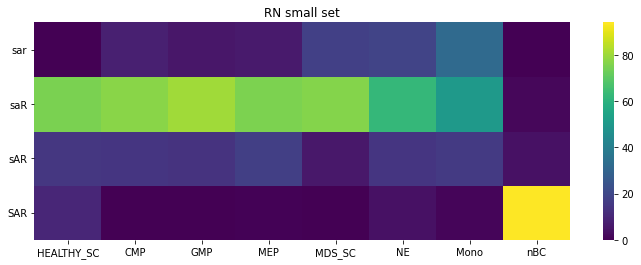

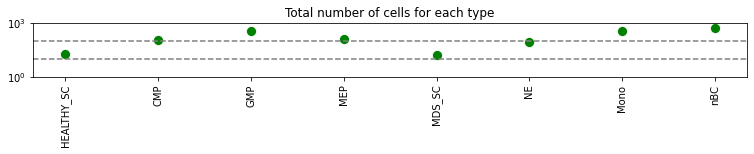

In [129]:
RNsmall2_plot = plot_index_heatmap_small(RNsmall2, "RN small set")

In [115]:
y = RNsmall2_plot*100/RNsmall2_plot.sum(axis = 0)
y



celltype,HEALTHY_SC,CMP,GMP,MEP,MDS_SC,NE,Mono,nBC
Haplotype,,,,,,,,
SAR,10.0,0.000000,0.000000,0.724638,0.000000,4.166667,1.440922,94.106090
sAR,15.0,14.414414,13.662791,17.391304,5.882353,14.583333,16.138329,4.322200
saR,75.0,77.477477,80.813953,75.362319,76.470588,62.500000,50.432277,1.571709
sar,0.0,8.108108,5.523256,6.521739,17.647059,18.750000,31.988473,0.000000


In [116]:
y = RNsmall2_plot*100/RNsmall2_plot.sum(axis = 0)
test = pd.DataFrame(y.unstack())
test.columns = ['Freq']
test['celltype'] = test.index.get_level_values(0) 
test['Haplotype'] = test.index.get_level_values(1) 
test

Freq    celltype Haplotype
celltype   Haplotype                                 
HEALTHY_SC SAR        10.000000  HEALTHY_SC       SAR
           sAR        15.000000  HEALTHY_SC       sAR
           saR        75.000000  HEALTHY_SC       saR
           sar         0.000000  HEALTHY_SC       sar
CMP        SAR         0.000000         CMP       SAR
           sAR        14.414414         CMP       sAR
           saR        77.477477         CMP       saR
           sar         8.108108         CMP       sar
GMP        SAR         0.000000         GMP       SAR
           sAR        13.662791         GMP       sAR
           saR        80.813953         GMP       saR
           sar         5.523256         GMP       sar
MEP        SAR         0.724638         MEP       SAR
           sAR        17.391304         MEP       sAR
           saR        75.362319         MEP       saR
           sar         6.521739         MEP       sar
MDS_SC     SAR         0.000000      MDS_SC       SAR
           sAR         5.882353      MDS_SC       sAR
           saR        76.470588      MDS_SC       saR
           sar        17.647059      MDS_SC       sar
NE         SAR         4.166667          NE       SAR
           sAR        14.583333          NE       sAR
           saR        62.500000          NE       saR
           sar        18.750000          NE       sar
Mono       SAR         1.440922        Mono       SAR
           sAR        16.138329        Mono       sAR
           saR        50.432277        Mono       saR
           sar        31.988473        Mono       sar
nBC        SAR        94.106090         nBC       SAR
           sAR         4.322200         nBC       sAR
           saR         1.571709         nBC       saR
           sar         0.000000         nBC       sar

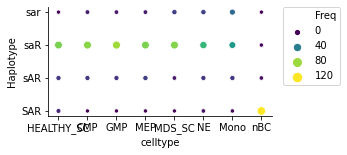

In [117]:
fig, ax = plt.subplots(figsize = (4,2))
sns.scatterplot(x = 'celltype', y = 'Haplotype',  data = test, size = 'Freq', ax = ax, hue = 'Freq', palette = 'viridis')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,title=None)
sns.despine(fig = fig)

In [118]:
RNsmall2_plot

celltype,HEALTHY_SC,CMP,GMP,MEP,MDS_SC,NE,Mono,nBC
Haplotype,,,,,,,,
SAR,2,0,0,1,0,4,5,479
sAR,3,16,47,24,1,14,56,22
saR,15,86,278,104,13,60,175,8
sar,0,9,19,9,3,18,111,0


In [119]:
new_col = []
for index, row in test.iterrows():
    if row['Haplotype'] == 'SAR':
        new_col.append(0)
    elif row['Haplotype'] == 'sAR':
        new_col.append(1)
    elif row['Haplotype'] == 'saR':
        new_col.append(2)
    elif row['Haplotype'] == 'sar':
        new_col.append(3)        
        
test['mut_no'] = new_col

test

Freq    celltype Haplotype  mut_no
celltype   Haplotype                                         
HEALTHY_SC SAR        10.000000  HEALTHY_SC       SAR       0
           sAR        15.000000  HEALTHY_SC       sAR       1
           saR        75.000000  HEALTHY_SC       saR       2
           sar         0.000000  HEALTHY_SC       sar       3
CMP        SAR         0.000000         CMP       SAR       0
           sAR        14.414414         CMP       sAR       1
           saR        77.477477         CMP       saR       2
           sar         8.108108         CMP       sar       3
GMP        SAR         0.000000         GMP       SAR       0
           sAR        13.662791         GMP       sAR       1
           saR        80.813953         GMP       saR       2
           sar         5.523256         GMP       sar       3
MEP        SAR         0.724638         MEP       SAR       0
           sAR        17.391304         MEP       sAR       1
           saR        75.362319         MEP       saR       2
           sar         6.521739         MEP       sar       3
MDS_SC     SAR         0.000000      MDS_SC       SAR       0
           sAR         5.882353      MDS_SC       sAR       1
           saR        76.470588      MDS_SC       saR       2
           sar        17.647059      MDS_SC       sar       3
NE         SAR         4.166667          NE       SAR       0
           sAR        14.583333          NE       sAR       1
           saR        62.500000          NE       saR       2
           sar        18.750000          NE       sar       3
Mono       SAR         1.440922        Mono       SAR       0
           sAR        16.138329        Mono       sAR       1
           saR        50.432277        Mono       saR       2
           sar        31.988473        Mono       sar       3
nBC        SAR        94.106090         nBC       SAR       0
           sAR         4.322200         nBC       sAR       1
           saR         1.571709         nBC       saR       2
           sar         0.000000         nBC       sar       3

In [120]:
new_col = []
for index, row in RNsmall2.iterrows():
    if row['Haplotype'] == 'SAR':
        new_col.append(0)
    elif row['Haplotype'] == 'sAR':
        new_col.append(1)
    elif row['Haplotype'] == 'saR':
        new_col.append(2)
    elif row['Haplotype'] == 'sar':
        new_col.append(3)        
        
RNsmall2['mut_no'] = new_col


<ipython-input-120-370e43185e84>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RNsmall2['mut_no'] = new_col


In [121]:
RNsmall2[['Haplotype', 'celltype', 'mut_no']]

,Haplotype,celltype,mut_no
1,SAR,nBC,0
2,SAR,nBC,0
3,SAR,nBC,0
4,SAR,nBC,0
5,SAR,nBC,0
...,...,...,...
1747,saR,NE,2
1749,saR,NE,2
1750,saR,NE,2
1752,saR,NE,2


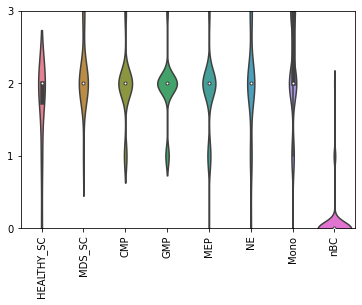

In [130]:
fig, ax = plt.subplots()
sns.violinplot(x = 'celltype', y = 'mut_no', ax = ax, data = RNsmall2, palette = colors, order = ['HEALTHY_SC','MDS_SC','CMP',  'GMP', 'MEP',   'NE', 'Mono','nBC'])
ax.set_ylim(0, 3)
ax.set_yticks([0,1,2,3])
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', labelrotation = 90)
fig.savefig('../Results/Haplotypes/RN_no_muts_violin.png',bbox_inches='tight',dpi=300)